In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Viewing quality of masks

Mask shape: (256, 256)
Mask data type: uint8
Unique values in mask: [0 1 2 3 4 5 6 7 8 9]
Dominant value: 6
Frequency: 56311
Value range in the mask: 0 to 9


(-0.5, 255.5, 255.5, -0.5)

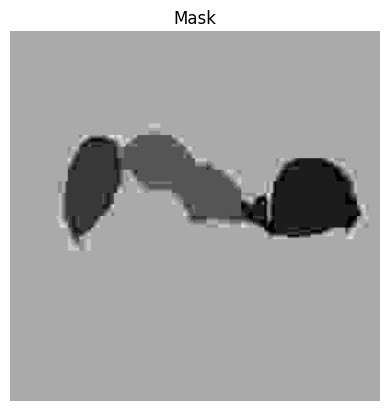

In [127]:
mask_path = 'masks_folder/mask_0.jpg'

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

print("Mask shape:", mask.shape)
print("Mask data type:", mask.dtype)

unique, counts = np.unique(mask, return_counts=True)
dominant_value = unique[np.argmax(counts)]
print("Unique values in mask:", unique)
print("Dominant value:", dominant_value)
print("Frequency:", counts[np.argmax(counts)])

min_val, max_val = mask.min(), mask.max()
print(f"Value range in the mask: {min_val} to {max_val}")

plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.axis("off")

Mask are represented as greyscale images with a low range of values. This will need to be normalised later (to 0-255). We can identify the background as value 6 as its present value, which we need to find the normalised value for. 

We want to filter away this specific colour for the background.

Mask shape: (808, 1164, 3)
Mask data type: uint8


(-0.5, 1163.5, 807.5, -0.5)

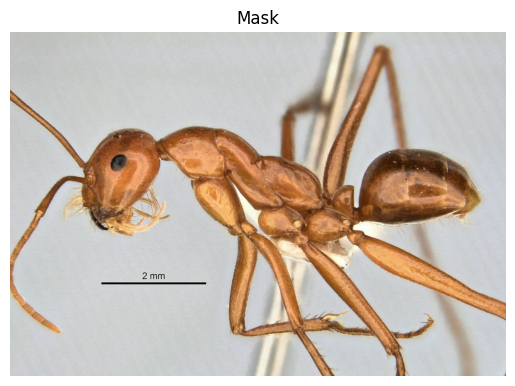

In [128]:
image_path = 'images_folder/image_0.jpg'

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print("Mask shape:", image.shape)
print("Mask data type:", image.dtype)

plt.imshow(image, cmap='gray')
plt.title("Mask")
plt.axis("off")

Obvious low quality in the masks, and must be resized to be layered with the original image.

In [129]:
# Checking how only resizing performs when overlaying on the image

def replace_background_with_color(
    image, mask, output_path=None, background_color=(255, 0, 255), background_value=6
):
    # Load the image if a file path is provided
    if isinstance(image, str):
        image = cv2.imread(image)
        if image is None:
            raise ValueError(f"Error loading the image from {image}. Check the path and format.")
    elif not isinstance(image, np.ndarray):
        raise ValueError("Image must be a file path or a NumPy array.")

    # Load the mask if a file path is provided
    if isinstance(mask, str):
        mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise ValueError(f"Error loading the mask from {mask}. Check the path and format.")
    elif not isinstance(mask, np.ndarray):
        raise ValueError("Mask must be a file path or a NumPy array.")

    if mask.shape != image.shape[:2]:
        mask_resized = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
    else:
        mask_resized = mask

    mask_no_background = np.where(mask_resized == background_value, 0, mask_resized)

    _, binary_mask = cv2.threshold(mask_no_background, 0, 255, cv2.THRESH_BINARY)
    binary_mask_3ch = binary_mask[:, :, None]
    background = np.full_like(image, background_color, dtype=np.uint8)
    result = np.where(binary_mask_3ch == 255, image, background)

    if output_path:
        cv2.imwrite(output_path, result)
        print(f"Processed and saved output to {output_path}")

    return result


def visualize_images(image_rgb, mask_resized, result_rgb):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image_rgb)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask_resized, cmap="gray")
    plt.title("Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(result_rgb)
    plt.title("Image with Replaced Background")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

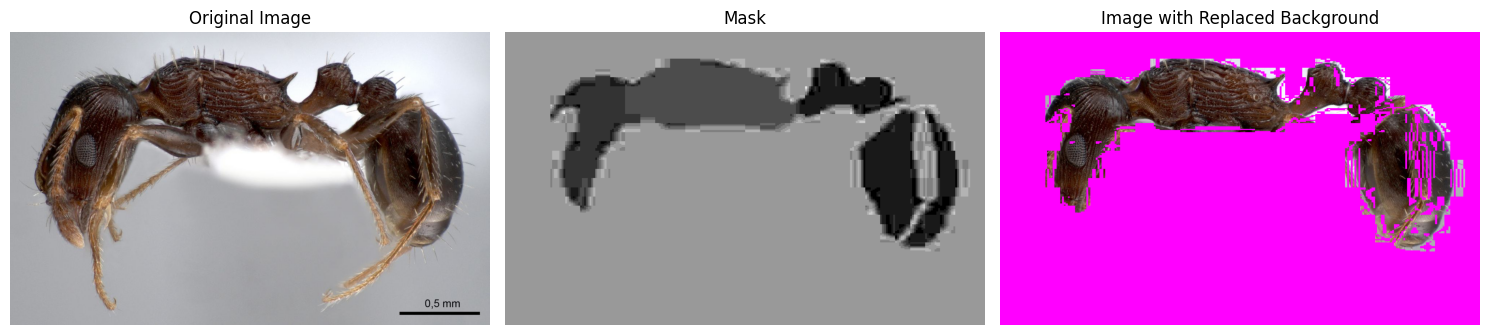

In [137]:
image_path = 'images_folder/image_2.jpg'
mask_path = 'masks_folder/mask_2.jpg'

image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
mask_resized = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

result_rgb = replace_background_with_color(
    image=image_rgb,
    mask=mask,
    background_color=(255, 0, 255),
    background_value=6 # Not normalised yet
)

visualize_images(image_rgb, mask_resized, result_rgb)

Quality of the .jpg masks leads to a very "unclear" masking here. Likely a consequence of .jpg compression? Looking at things to do to improve the quality to have a cleaner cut, otherwise we need to figure out how to convert the images .png to .jpg in a better way. 

# Improving quality of masks

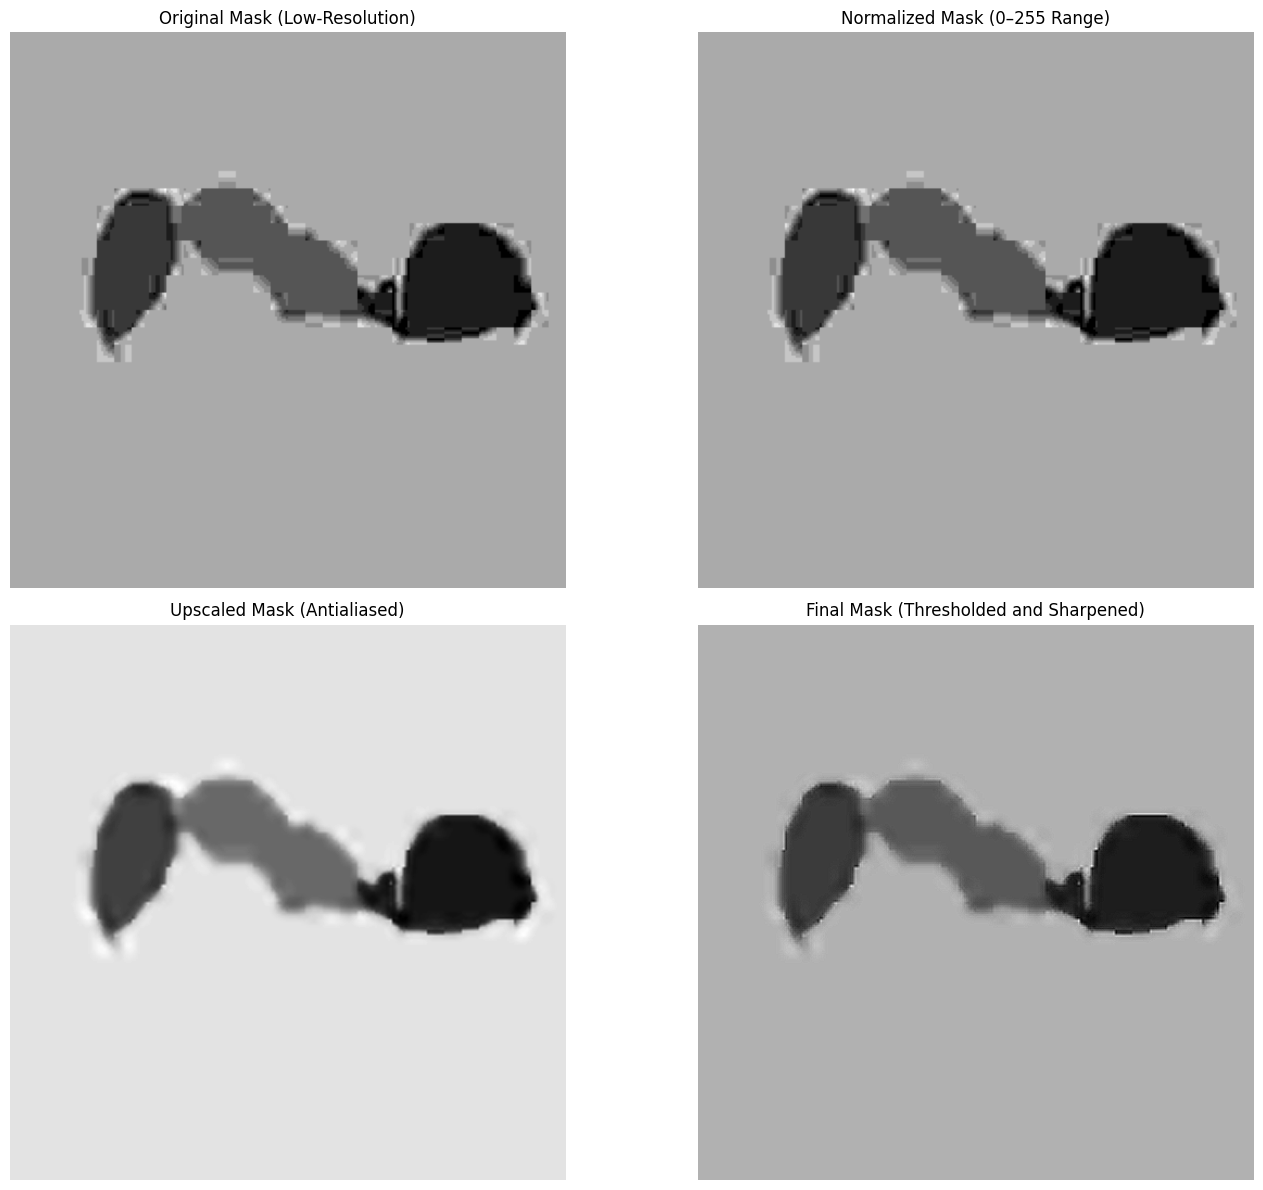

In [131]:
mask_path = 'masks_folder/mask_0.jpg'
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
if mask is None:
    raise ValueError(f"Error loading mask from {mask_path}.")

def normalize_and_finalize_mask(mask):
    normalized_mask = cv2.normalize(mask, None, 0, 255, cv2.NORM_MINMAX)

    # Bilateral Filtering: Smooth while preserving edges
    smoothed_mask = cv2.bilateralFilter(normalized_mask, d=9, sigmaColor=75, sigmaSpace=75)

    # Upscaling with Antialiasing: Increase resolution with cubic interpolation
    upscale_factor = 2
    height, width = mask.shape
    upscaled_mask = cv2.resize(smoothed_mask, (width * upscale_factor, height * upscale_factor),
                                interpolation=cv2.INTER_CUBIC)
    
    # Apply Strong Sharpening
    strong_sharpening_kernel = np.array([[0, -1, 0],
                                     [-1, 5, -1],
                                     [0, -1, 0]])
    refined_mask = cv2.filter2D(upscaled_mask, -1, strong_sharpening_kernel)

    return normalized_mask, smoothed_mask, upscaled_mask, refined_mask


normalized_mask, smoothed_mask, upscaled_mask, sharpened_mask = normalize_and_finalize_mask(mask)

plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
plt.imshow(mask, cmap="gray")
plt.title("Original Mask (Low-Resolution)")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(normalized_mask, cmap="gray")
plt.title("Normalized Mask (0–255 Range)")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(upscaled_mask, cmap="gray")
plt.title("Upscaled Mask (Antialiased)")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(sharpened_mask, cmap="gray")
plt.title("Final Mask (Thresholded and Sharpened)")
plt.axis("off")

plt.tight_layout()
plt.show()

# Spitting up into head, body and bottom

In [27]:
from sklearn.cluster import KMeans

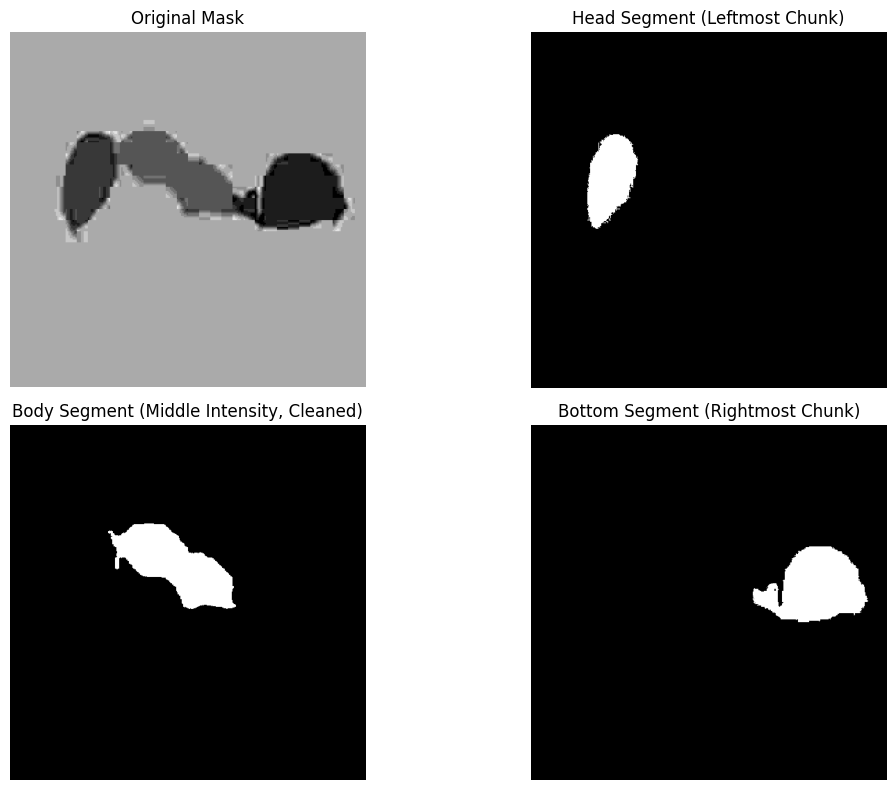

In [132]:
def clean_middle_intensity(mask, min_region_size=500):
    # Morphological opening to remove contours
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    opened_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Connected components analysis to filter small regions
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(opened_mask)
    cleaned_mask = np.zeros_like(mask)

    # Retain only the largest region
    largest_region_index = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    cleaned_mask[labels == largest_region_index] = 255

    return cleaned_mask


def split_low_intensity_chunks(mask, min_region_size=500, split_ratio=0.5):
    _, binary_mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)

    # Perform connected components analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask)

    # Initialize masks for head and bottom
    head_mask = np.zeros_like(mask, dtype=np.uint8)
    bottom_mask = np.zeros_like(mask, dtype=np.uint8)

    # Determine the split point
    split_x = int(mask.shape[1] * split_ratio)

    # Iterate through each region and assign it to head or bottom based on its horizontal position
    for i in range(1, num_labels): 
        area = stats[i, cv2.CC_STAT_AREA]
        if area >= min_region_size:
            # Compute the region's horizontal position
            region_x = stats[i, cv2.CC_STAT_LEFT] + stats[i, cv2.CC_STAT_WIDTH] // 2

            if region_x <= split_x:
                # Assign to head
                head_mask[labels == i] = 255
            else:
                # Assign to bottom
                bottom_mask[labels == i] = 255

    return head_mask, bottom_mask


def segment_and_clean_mask(mask, n_clusters=3, background_value=6, min_region_size=500):
    # Exclude the background
    non_background_mask = mask != background_value
    non_background_pixels = mask[non_background_mask].reshape(-1, 1)
    
    # Apply k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(non_background_pixels)
    clustered = np.full_like(mask, fill_value=-1, dtype=np.int32)  # Initialize with -1 (background placeholder)
    clustered[non_background_mask] = kmeans.labels_

    # Sort clusters by intensity (remove high intensity)
    cluster_centers = kmeans.cluster_centers_.flatten()
    sorted_clusters = np.argsort(cluster_centers)  # Sort clusters by intensity
    low_cluster, middle_cluster, high_cluster = sorted_clusters  # Assign based on intensity order
    clustered[clustered == high_cluster] = -1  # Remove high-intensity cluster

    # Process middle intensity cluster (remove contours and retain solid regions)
    middle_mask = (clustered == middle_cluster).astype(np.uint8) * 255
    body_mask = clean_middle_intensity(middle_mask, min_region_size)

    # Split low-intensity mask into head and bottom chunks
    low_mask = (clustered == low_cluster).astype(np.uint8) * 255
    head_mask, bottom_mask = split_low_intensity_chunks(low_mask)

    return head_mask, body_mask, bottom_mask

head_mask, body_mask, bottom_mask = segment_and_clean_mask(sharpened_mask, n_clusters=3, background_value=170, min_region_size=500)

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.imshow(mask, cmap="gray")
plt.title("Original Mask")
plt.axis("off")

# Head segment
plt.subplot(2, 2, 2)
plt.imshow(head_mask, cmap="gray")
plt.title("Head Segment (Leftmost Chunk)")
plt.axis("off")

# Body segment
plt.subplot(2, 2, 3)
plt.imshow(body_mask, cmap="gray")
plt.title("Body Segment (Middle Intensity, Cleaned)")
plt.axis("off")

# Bottom segment
plt.subplot(2, 2, 4)
plt.imshow(bottom_mask, cmap="gray")
plt.title("Bottom Segment (Rightmost Chunk)")
plt.axis("off")

plt.tight_layout()
plt.show()

In [68]:
import os

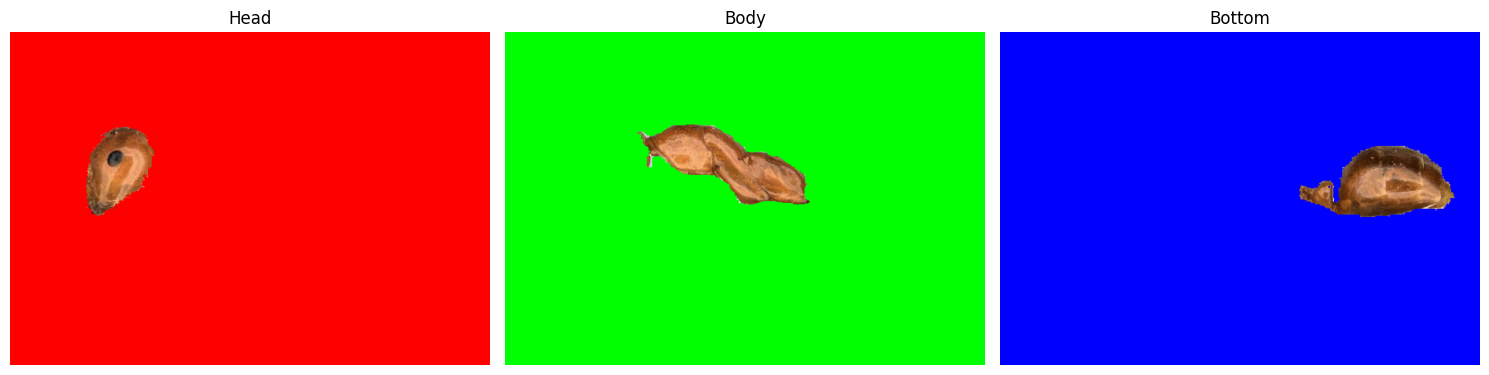

In [133]:
image_path = 'images_folder/image_0.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask_path = 'masks_folder/mask_0.jpg'
mask_path = os.path.abspath(mask_path)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
if mask is None:
    raise ValueError(f"Error loading mask from {mask_path}.")

background_value = 170
refined_mask = normalize_and_finalize_mask(mask)[-1]

head_mask, body_mask, bottom_mask = segment_and_clean_mask(refined_mask, background_value=background_value)

head = replace_background_with_color(image, head_mask, background_color=(255, 0, 0))
body = replace_background_with_color(image, body_mask, background_color=(0, 255, 0))
bottom = replace_background_with_color(image, bottom_mask, background_color=(0, 0, 255))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(head)
plt.title("Head")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(body)
plt.title("Body")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(bottom)
plt.title("Bottom")
plt.axis("off")

plt.tight_layout()
plt.show()


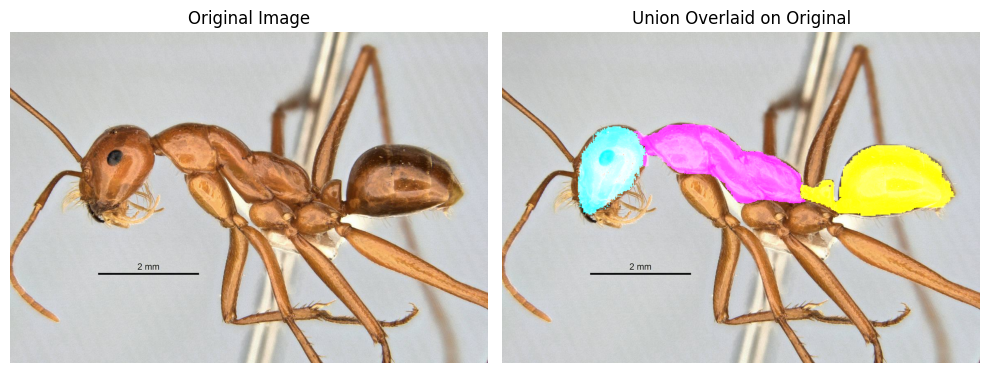

In [134]:
union = np.maximum(np.maximum(head, body), bottom)

def overlay_union_on_original(original_image, union_image, background_color=(255, 255, 255)):
    background_color = np.array(background_color, dtype=np.uint8)
    non_background_mask = ~np.all(union_image == background_color, axis=-1)
    overlaid_image = original_image.copy()
    overlaid_image[non_background_mask] = union_image[non_background_mask]

    return overlaid_image

overlaid_image = overlay_union_on_original(image, union, background_color=(255, 255, 255))

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlaid_image)
plt.title("Union Overlaid on Original")
plt.axis("off")

plt.tight_layout()
plt.show()

In [138]:
def calculate_average_rgb(segment, background_color=(255, 0, 255)):
    background_color = np.array(background_color, dtype=np.uint8)

    mask = ~np.all(segment == background_color, axis=-1)
    non_background_pixels = segment[mask]

    if non_background_pixels.size == 0:
        raise ValueError("No non-background pixels found in the segment.")

    avg_rgb = np.median(non_background_pixels, axis=0)

    return tuple(avg_rgb.astype(int))

Head Average RGB: (167, 99, 53)
Body Average RGB: (184, 117, 70)
Bottom Average RGB: (130, 81, 45)


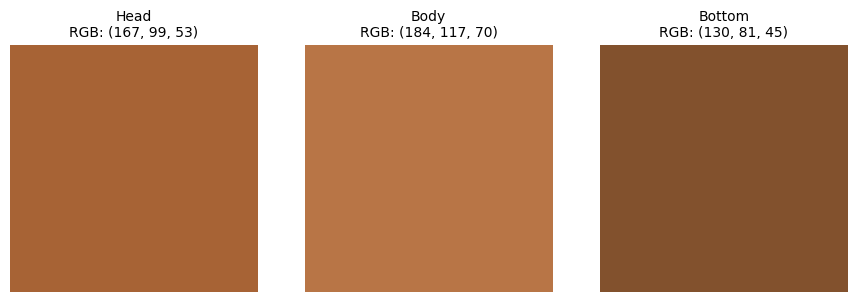

In [139]:
head_avg_rgb = calculate_average_rgb(head, background_color=(255, 0, 0))
body_avg_rgb = calculate_average_rgb(body, background_color=(0, 255, 0))
bottom_avg_rgb = calculate_average_rgb(bottom, background_color=(0, 0, 255))

print("Head Average RGB:", head_avg_rgb)
print("Body Average RGB:", body_avg_rgb)
print("Bottom Average RGB:", bottom_avg_rgb)

colors = [head_avg_rgb, body_avg_rgb, bottom_avg_rgb]
labels = ["Head", "Body", "Bottom"]

fig, ax = plt.subplots(1, 3, figsize=(9, 3))

for i, (color, label) in enumerate(zip(colors, labels)):
    color_square = np.ones((100, 100, 3), dtype=np.uint8) * np.array(color, dtype=np.uint8)
    ax[i].imshow(color_square)
    ax[i].axis("off")
    ax[i].set_title(f"{label}\nRGB: {color}", fontsize=10)

plt.tight_layout()
plt.show()

In [142]:
# Check for all files
def ensure_directory_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

head_dir = "output/heads"
body_dir = "output/bodies"
bottom_dir = "output/bottoms"
union_dir = "output/unions"

ensure_directory_exists(head_dir)
ensure_directory_exists(body_dir)
ensure_directory_exists(bottom_dir)
ensure_directory_exists(union_dir)

images_folder = "images_folder"
masks_folder = "masks_folder"


for image_file in os.listdir(images_folder):
    # Ensure it's an image file
    if not image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    mask_filename = image_file.replace('image', 'mask')

    # Corresponding mask file
    mask_file = os.path.join(masks_folder, mask_filename)
    if not os.path.exists(mask_file):
        print(f"Mask file not found for {image_file}, skipping.")
        continue

    # Load image and mask
    image_path = os.path.join(images_folder, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"Error loading mask for {image_file}, skipping.")
        continue

    # Process the mask
    background_value = 170
    refined_mask = normalize_and_finalize_mask(mask)[-1]

    # Segment the mask into head, body, and bottom
    head_mask, body_mask, bottom_mask = segment_and_clean_mask(refined_mask, background_value=background_value)

    # Create colored overlays for head, body, and bottom
    head = replace_background_with_color(image, head_mask, background_color=(255, 0, 0))
    body = replace_background_with_color(image, body_mask, background_color=(0, 255, 0))
    bottom = replace_background_with_color(image, bottom_mask, background_color=(0, 0, 255))

    # Create the union of the segments
    union = np.maximum(np.maximum(head, body), bottom)

    # Save the outputs
    base_filename = os.path.splitext(image_file)[0]  # Get the base file name without extension
    head_path = os.path.join(head_dir, f"{base_filename}_head.png")
    body_path = os.path.join(body_dir, f"{base_filename}_body.png")
    bottom_path = os.path.join(bottom_dir, f"{base_filename}_bottom.png")
    union_path = os.path.join(union_dir, f"{base_filename}_union.png")

    cv2.imwrite(head_path, cv2.cvtColor(head, cv2.COLOR_RGB2BGR))
    cv2.imwrite(body_path, cv2.cvtColor(body, cv2.COLOR_RGB2BGR))
    cv2.imwrite(bottom_path, cv2.cvtColor(bottom, cv2.COLOR_RGB2BGR))
    cv2.imwrite(union_path, cv2.cvtColor(union, cv2.COLOR_RGB2BGR))

    print(f"Processed and saved outputs for {image_file}:")
    print(f"  Head -> {head_path}")
    print(f"  Body -> {body_path}")
    print(f"  Bottom -> {bottom_path}")
    print(f"  Union -> {union_path}")

Processed and saved outputs for image_187.jpg:
  Head -> output/heads/image_187_head.png
  Body -> output/bodies/image_187_body.png
  Bottom -> output/bottoms/image_187_bottom.png
  Union -> output/unions/image_187_union.png
Processed and saved outputs for image_178.jpg:
  Head -> output/heads/image_178_head.png
  Body -> output/bodies/image_178_body.png
  Bottom -> output/bottoms/image_178_bottom.png
  Union -> output/unions/image_178_union.png
Processed and saved outputs for image_150.jpg:
  Head -> output/heads/image_150_head.png
  Body -> output/bodies/image_150_body.png
  Bottom -> output/bottoms/image_150_bottom.png
  Union -> output/unions/image_150_union.png
Processed and saved outputs for image_144.jpg:
  Head -> output/heads/image_144_head.png
  Body -> output/bodies/image_144_body.png
  Bottom -> output/bottoms/image_144_bottom.png
  Union -> output/unions/image_144_union.png
Processed and saved outputs for image_15.jpg:
  Head -> output/heads/image_15_head.png
  Body -> out